# Statistik-Projekt HS25 – Multiple Regression & Interaktionen
## Notebook 11: Interaktionseffekte & Multikollinearität (VIF)

In diesem Notebook erweitern wir das Modell aus N10 um Interaktionseffekte
und bewerten die Stabilität der Schätzer über Variance Inflation Factors (VIF).

**Ziel:** Prüfen, ob ein Interaktionsmodell (Stunde × Wochentag) die
Verspätungen besser beschreibt als das einfachere Modell aus N10 – und ob
dabei problematische Multikollinearität auftritt.

## Imports und Daten laden

In [2]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "../data/processed/istdata_clean.parquet"

# Wie viele Beobachtungen sollen für die Regression verwendet werden?
# 200_000 – 500_000 ist ein guter Kompromiss aus Stabilität und Laufzeit.
SAMPLE_SIZE = 500_000

# Daten mit Polars laden und vorbereiten
df_pl = (
    pl.read_parquet(DATA_PATH)
    .select(["delay_arrival_s", "ANKUNFTSZEIT", "Wochentag"])
    .with_columns([
        (pl.col("delay_arrival_s") / 60).alias("delay_min"),
        pl.col("ANKUNFTSZEIT").dt.hour().alias("hour"),
    ])
    .drop_nulls()
)

# Zufällige Stichprobe ziehen, um RAM zu sparen
if SAMPLE_SIZE is not None and SAMPLE_SIZE < df_pl.height:
    df_pl = df_pl.sample(n=SAMPLE_SIZE, shuffle=True, seed=42)

print(f"Anzahl Beobachtungen in N11: {df_pl.height:,}")

# Für statsmodels brauchen wir ein pandas-DataFrame
df = df_pl.to_pandas()

# Negative Verspätungen auf 0 setzen (Frühankünfte nicht als „negative Verspätung“ werten)
df["delay_clean"] = df["delay_min"].clip(lower=0)

# Log-transformierte Zielvariable (stabilere Varianz)
df["delay_log"] = np.log1p(df["delay_clean"])

df.head()

Anzahl Beobachtungen in N11: 500,000


,delay_arrival_s,ANKUNFTSZEIT,Wochentag,delay_min,hour,delay_clean,delay_log
0,322.0,2025-09-25 13:46:00+00:00,Thursday,5.366667,13,5.366667,1.851076
1,18.0,2025-10-09 17:15:00+00:00,Wednesday,0.300000,17,0.300000,0.262364
2,94.0,2025-09-30 12:01:00+00:00,Tuesday,1.566667,12,1.566667,0.942608
3,197.0,2025-09-22 19:10:00+00:00,Monday,3.283333,19,3.283333,1.454732
4,98.0,2025-09-24 11:00:00+00:00,Wednesday,1.633333,11,1.633333,0.968250


## Basis Modell

In [3]:
model_base = smf.ols(
    "delay_log ~ hour + I(hour**2) + C(Wochentag)",
    data=df
).fit()

print("=== Basis-Modell (Stichprobe) ===")
print(model_base.summary())

=== Basis-Modell (Stichprobe) ===
                            OLS Regression Results                            
Dep. Variable:              delay_log   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     386.5
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:28:24   Log-Likelihood:            -4.3095e+05
No. Observations:              500000   AIC:                         8.619e+05
Df Residuals:                  499991   BIC:                         8.620e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

## Modell 2: Modell mit Interaktion (hour × Wochentag)

In [4]:
model_interact = smf.ols(
    "delay_log ~ hour * C(Wochentag) + I(hour**2)",
    data=df
).fit()

print("=== Interaktions-Modell: hour × Wochentag (Stichprobe) ===")
print(model_interact.summary())

=== Interaktions-Modell: hour × Wochentag (Stichprobe) ===
                            OLS Regression Results                            
Dep. Variable:              delay_log   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     238.4
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        18:28:39   Log-Likelihood:            -4.3083e+05
No. Observations:              500000   AIC:                         8.617e+05
Df Residuals:                  499985   BIC:                         8.619e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

## Modellvergleich: AIC & BIC

In [5]:
print("=== Modellvergleich (AIC / BIC, kleinere Werte sind besser) ===")
print(f"AIC Basis-Modell:           {model_base.aic:,.0f}")
print(f"AIC Interaktions-Modell:    {model_interact.aic:,.0f}")
print(f"BIC Basis-Modell:           {model_base.bic:,.0f}")
print(f"BIC Interaktions-Modell:    {model_interact.bic:,.0f}")

=== Modellvergleich (AIC / BIC, kleinere Werte sind besser) ===
AIC Basis-Modell:           861,927
AIC Interaktions-Modell:    861,695
BIC Basis-Modell:           862,027
BIC Interaktions-Modell:    861,862


## Multikollinearität prüfen: VIF für das Interaktions-Modell

Vollständige Designmatrix: 500,000 Zeilen, 15 Spalten
VIF-Berechnung auf Stichprobe mit 50,000 Zeilen.


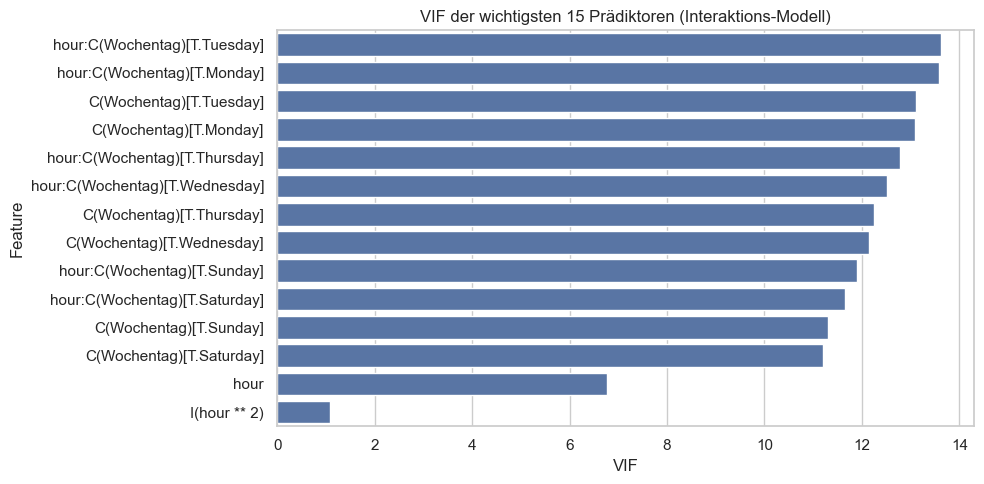

In [7]:
X_full = model_interact.model.exog
feature_names = model_interact.model.exog_names

print(f"Vollständige Designmatrix: {X_full.shape[0]:,} Zeilen, {X_full.shape[1]} Spalten")

# Für die VIF-Berechnung zusätzlich auf max. 50'000 Zeilen herunter-sampeln
max_rows_vif = 50_000
if X_full.shape[0] > max_rows_vif:
    step = int(np.ceil(X_full.shape[0] / max_rows_vif))
    X = X_full[::step, :]
    print(f"VIF-Berechnung auf Stichprobe mit {X.shape[0]:,} Zeilen.")
else:
    X = X_full

vif_values = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X, i)
    vif_values.append(vif)

vif_df = pd.DataFrame({
    "feature": feature_names,
    "VIF": vif_values
})

# Intercept rausfiltern, weil VIF dort nicht interpretierbar ist
vif_df = vif_df[vif_df["feature"] != "Intercept"].reset_index(drop=True)

vif_df.sort_values("VIF", ascending=False).head(15)

top_n = 15
vif_top = vif_df.sort_values("VIF", ascending=False).head(top_n)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=vif_top,
    x="VIF",
    y="feature",
    orient="h"
)
plt.title(f"VIF der wichtigsten {top_n} Prädiktoren (Interaktions-Modell)")
plt.xlabel("VIF")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Interpretation

Das Interaktionsmodell zeigt im Vergleich zum Basismodell nur eine sehr kleine Verbesserung (R² steigt von etwa 0.006 auf 0.007). Auch AIC und BIC werden leicht besser, jedoch bleibt der praktische Erklärungsgewinn minimal. Die Interaktionseffekte verändern somit das Modell, erhöhen aber die tatsächliche Vorhersagekraft kaum.

Die VIF-Analyse zeigt erhöhte Werte bei Wochentagsvariablen und deren Interaktionen (ungefähr 10–14). Das deutet auf erwartbare Multikollinearität hin, da Dummy-Variablen und Interaktionsterme sich häufig überschneiden. Für die Modellinterpretation ist das nicht kritisch, zeigt aber, dass das Modell strukturell redundant wird.

## Fazit

Auch mit Interaktionseffekten bleibt die lineare Regression nur sehr begrenzt erklärungsfähig. Die täglichen und wöchentlichen Muster tragen kaum zur Variabilität der Verspätungen bei. Lineare Modelle erfassen die zugrunde liegenden Prozesse offensichtlich nicht gut. Für bessere Ergebnisse wären komplexere, nichtlineare Ansätze oder Machine-Learning-Methoden besser geeignet.